In [1]:
!pip install -q efficientnet
!pip install -q pyyaml h5py

#basic libraries
import os, re, math, cv2
import numpy as np
import pandas as pd

#plot libraries
import matplotlib.pyplot as plt
import plotly.express as px

#utilities library
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

#background library for learning 
import tensorflow as tf
import tensorflow.keras.layers as L
# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from kaggle_datasets import KaggleDatasets

import efficientnet.tfkeras as efn

2021-11-24 23:18:50.478834: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-24 23:18:50.478979: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2021-11-24 23:18:55.258983: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-24 23:18:55.261934: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-24 23:18:55.261970: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-24 23:18:55.261998: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (31e39184cf07): /proc/driver/nvidia/version does not exist
2021-11-24 23:18:55.264888: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [3]:
# Read files
train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test_df  = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')


In [4]:
print('Training set contains {} images of {} unique patients, resulting in a ratio of {} images per patient'.format(train_df.shape[0],
                                                                                                                     train_df.patient_id.nunique(),
                                                                                                                     round(train_df.shape[0] / train_df.patient_id.nunique(),2)
                                                                                                                    ))

print('Testing  set contains {} images of {}  unique patients, resulting in a ratio of {} images per patient'.format(test_df.shape[0],
                                                                                                                 test_df.patient_id.nunique(),
                                                                                                                 round(test_df.shape[0] / test_df.patient_id.nunique(),2)
                                                                                                                ))

Training set contains 33126 images of 2056 unique patients, resulting in a ratio of 16.11 images per patient
Testing  set contains 10982 images of 690  unique patients, resulting in a ratio of 15.92 images per patient


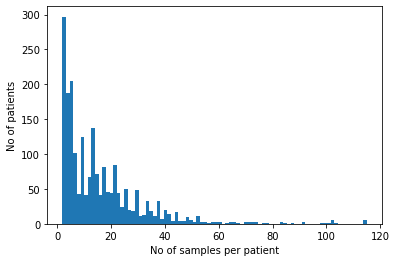

Minimum no of sample taken from  single patient 2
Maximum no of sample taken from  single patient 115
There are  16  samples taken from each patients on average
Median of no. of samples taken from  single patient 12
Mode of no. of samples taken from  single patient 3


In [5]:
image_freq_per_patient = train_df.groupby(['patient_id']).count()['image_name']
plt.hist(image_freq_per_patient.tolist(), bins = image_freq_per_patient.nunique())
plt.xlabel('No of samples per patient')
plt.ylabel('No of patients')
plt.show()
print('Minimum no of sample taken from  single patient', image_freq_per_patient.min())
print('Maximum no of sample taken from  single patient', image_freq_per_patient.max())
print('There are ',int( image_freq_per_patient.mean()), ' samples taken from each patients on average')
print('Median of no. of samples taken from  single patient', int(image_freq_per_patient.median()))
print('Mode of no. of samples taken from  single patient', int(image_freq_per_patient.mode()))

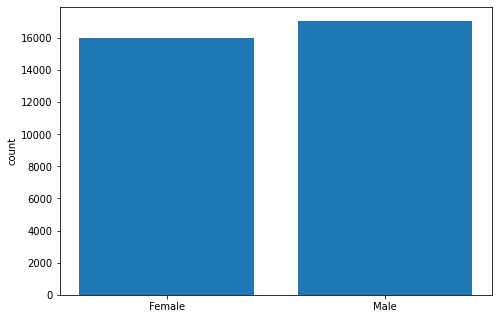

sex
female    15981
male      17080
Name: image_name, dtype: int64

In [6]:
sex_count = train_df.groupby(['sex']).count()['image_name']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['Female', 'Male'], sex_count)
plt.ylabel('count')
plt.show()
sex_count

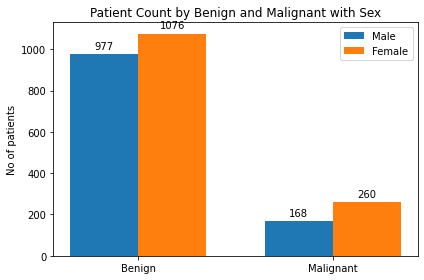

In [7]:
category_sex = train_df.groupby(['sex', 'benign_malignant']).nunique()['patient_id'].tolist()

labels = ['Benign', 'Malignant']
benign_data = category_sex[0:2]
maglignant_data = category_sex[2:4]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, benign_data, width, label='Male')
rects2 = ax.bar(x + width/2, maglignant_data, width, label='Female')
ax.set_ylabel('No of patients')
ax.set_title('Patient Count by Benign and Malignant with Sex')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

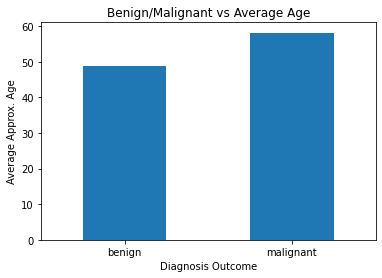

In [8]:
plt.figure()
train_df.groupby(['benign_malignant']).mean()['age_approx'].plot.bar(x = 'Diagnosis Type', y = 'Average age', rot = 0)
plt.title('Benign/Malignant vs Average Age')
plt.xlabel('Diagnosis Outcome')
plt.ylabel('Average Approx. Age')
plt.show()

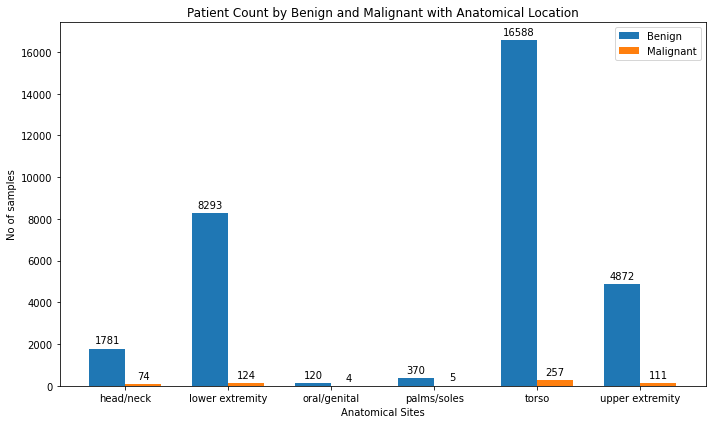

In [9]:
site_vs_diagnosis = train_df.groupby(['anatom_site_general_challenge', 'benign_malignant']).count()['patient_id'].tolist()
labels = ['head/neck', 'lower extremity', 'oral/genital','palms/soles', 'torso', 'upper extremity']
benign_data = site_vs_diagnosis[0:12:2]
maglignant_data = site_vs_diagnosis[1:12:2]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6))
rects1 = ax.bar(x - width/2, benign_data, width, label='Benign')
rects2 = ax.bar(x + width/2, maglignant_data, width, label='Malignant')
ax.set_ylabel('No of samples')
ax.set_xlabel('Anatomical Sites')
ax.set_title('Patient Count by Benign and Malignant with Anatomical Location')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


In [10]:
train_df.groupby(['benign_malignant', 'sex']).nunique()['patient_id']

benign_malignant  sex   
benign            female     977
                  male      1076
malignant         female     168
                  male       260
Name: patient_id, dtype: int64

In [11]:
# Encode 'unknowns' as NaNs
train_df['diagnosis'] = train_df.diagnosis.apply(lambda x: np.nan if x == 'unknown' else x)

labels_df = pd.DataFrame(train_df.benign_malignant.value_counts()).reset_index()
labels_df.columns = ['Label','Count']

# Create dataframe counting NaN values per column
nan_df = pd.DataFrame(train_df.isna().sum()).reset_index()
nan_df.columns  = ['Column', 'NaN_Count']
nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
nan_df['NaN_%'] = round(nan_df['NaN_Count']/train_df.shape[0] * 100,1)
nan_df['Type']  = 'Missingness'
nan_df.sort_values('NaN_%', inplace=True)


# Add completeness
for i in range(nan_df.shape[0]):
    complete_df = pd.DataFrame([nan_df.loc[i,'Column'],train_df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
    complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
    complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
    complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
    nan_df = nan_df.append(complete_df, sort=True)
    
    
# Missingness Plot
fig = px.bar(nan_df,
             x='Column',
             y='NaN_%',
             title='Missingness on the Training Set',
             color='Type',
             template='plotly_dark',
             opacity = 0.6,
             color_discrete_sequence=['#dbdbdb','#38cae0'])

fig.update_xaxes(title='Column Name')
fig.update_yaxes(title='NaN Percentage')
fig.show()

In [12]:
# Count NaNs
train_df.isnull().sum()

image_name                           0
patient_id                           0
sex                                 65
age_approx                          68
anatom_site_general_challenge      527
diagnosis                        27124
benign_malignant                     0
target                               0
dtype: int64

In [13]:
labels_df = pd.DataFrame(train_df.benign_malignant.value_counts()).reset_index()
labels_df.columns = ['Label','Count']

# Create dataframe counting NaN values per column
nan_df = pd.DataFrame(test_df.isna().sum()).reset_index()
nan_df.columns  = ['Column', 'NaN_Count']
nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
nan_df['NaN_%'] = round(nan_df['NaN_Count']/test_df.shape[0] * 100,1)
nan_df['Type']  = 'Missingness'
nan_df.sort_values('NaN_%', inplace=True)


# Add completeness
for i in range(nan_df.shape[0]):
    complete_df = pd.DataFrame([nan_df.loc[i,'Column'],test_df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
    complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
    complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
    complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
    nan_df = nan_df.append(complete_df, sort=True)
    
    
# Missingness Plot
fig = px.bar(nan_df,
             x='Column',
             y='NaN_%',
             title='Missingness on the Testing Set',
             color='Type',
             template='plotly_dark',
             opacity = 0.6,
             color_discrete_sequence=['#dbdbdb','#38cae0'])

fig.update_xaxes(title='Column Name')
fig.update_yaxes(title='NaN Percentage')
fig.show()

In [14]:
# Count NaNs
test_df.isnull().sum()

image_name                         0
patient_id                         0
sex                                0
age_approx                         0
anatom_site_general_challenge    351
dtype: int64

In [15]:
# Summarise data
count_df = labels_df.iloc[::-1]

# Create annotations
annotations = [dict(
            y=count_df.loc[i,'Label'],
            x=count_df.loc[i,'Count'] + 1000,
            text=str(round(count_df.loc[i,'Count']/train_df.shape[0]*100,1))+'%',
            font=dict(
            size=14,
            color="#000000"
            ),
            bordercolor="#c7c7c7",
            borderwidth=1,
            borderpad=4,
            bgcolor="#ffffff",
            opacity=0.95,
            showarrow=False,
        ) for i in range(count_df.shape[0])]



fig = px.bar(labels_df,
             y = 'Label',
             x = 'Count',
             title       = 'Label Distribution',
             template    = 'plotly_dark',
             orientation = 'h',
             opacity     = 0.7,
             color       = 'Label',
             color_discrete_sequence = ['#38cae0','#d1324d'] 
            )


fig.update_layout(showlegend=False, annotations = annotations)
fig.show()

In [16]:
fig = px.histogram(train_df,
             x     = 'age_approx',
             color = 'target',
             color_discrete_sequence = ['#38cae0','#d1324d'],
             barnorm  = 'fraction',
             template = 'plotly_dark',
             opacity  = 0.7,
             title    = 'Impact of Age across Diagnosis'
            )

fig.update_xaxes(title = 'Approximated Age', tickvals = list(range(0,91,5)))
fig.update_yaxes(title = 'Percentage of class total')
fig.show()

In [17]:
parallel_df = train_df.copy()

undersampled_df = pd.concat([parallel_df.query("target == 1"),resample(parallel_df.query("target == 0"),
                                                                       replace   = False,
                                                                       n_samples = 584,
                                                                       random_state = 451)
                            ],axis=0)


keep_list = ['sex','age_approx','anatom_site_general_challenge','target']
fig = px.parallel_categories(undersampled_df[keep_list],
                              color="target",
                              template='plotly_dark',
                              labels={"age_approx": "Approximate Age","sex": "Sex", 'anatom_site_general_challenge':'Anatomical Site','target':'Melanoma'},
                              color_continuous_scale=['#dbdbdb','#38cae0'],
                              title='Categorical Flow'
                             )

fig.update_layout(showlegend=False)
fig.show()

In [18]:
def prepare_dataframe(df):
    df['sex'] = np.where(df['sex'] == 'female',1,0)
    df = pd.concat([df.drop('anatom_site_general_challenge',axis=1), pd.get_dummies(df['anatom_site_general_challenge'])],axis=1)
    df = df.drop(['benign_malignant','image_name','patient_id','diagnosis'],axis=1)
    df.loc[df['age_approx'].isnull(),'age_approx'] = df['age_approx'].median()
    
    return(df)

def evaluate_predictions(preds, test_labels):
    '''
    Evaluate Predictions Function
    Returns accuracy and auc of the model
    '''
    auroc = roc_auc_score(test_labels.astype('uint8'), preds)
    accur = accuracy_score(test_labels.astype('uint8'), preds >= 0.5)
    print('Accuracy: ' + str(accur))
    print('AUC: ' + str(auroc))

In [19]:
# Split data
train, probe = train_test_split(prepare_dataframe(train_df),
                                test_size = 0.3,
                                stratify = train_df['target'],
                                random_state = 451
                               )

train_y = train.pop('target')
probe_y = probe.pop('target')

In [20]:
logit_model = LogisticRegression(random_state=451, solver='lbfgs', max_iter=1000)
logit_model.fit(train, train_y)

logit_preds = logit_model.predict_proba(probe)
evaluate_predictions(logit_preds[:,1], probe_y)

Accuracy: 0.9823908231032401
AUC: 0.663661930612663


In [21]:
fig = px.bar(y = logit_model.coef_.tolist()[0],
       x = probe.columns.tolist(),
       template = 'plotly_dark',
       title = 'Logistic Regression Coefficient Values',
       color = logit_model.coef_.tolist()[0],
       color_continuous_scale = ['#d1285b','#28b5d1'],
       opacity = 0.7
      )

fig.update_yaxes(title = 'Coefficient Value')
fig.update_xaxes(title = 'Variable Name')
fig.show()

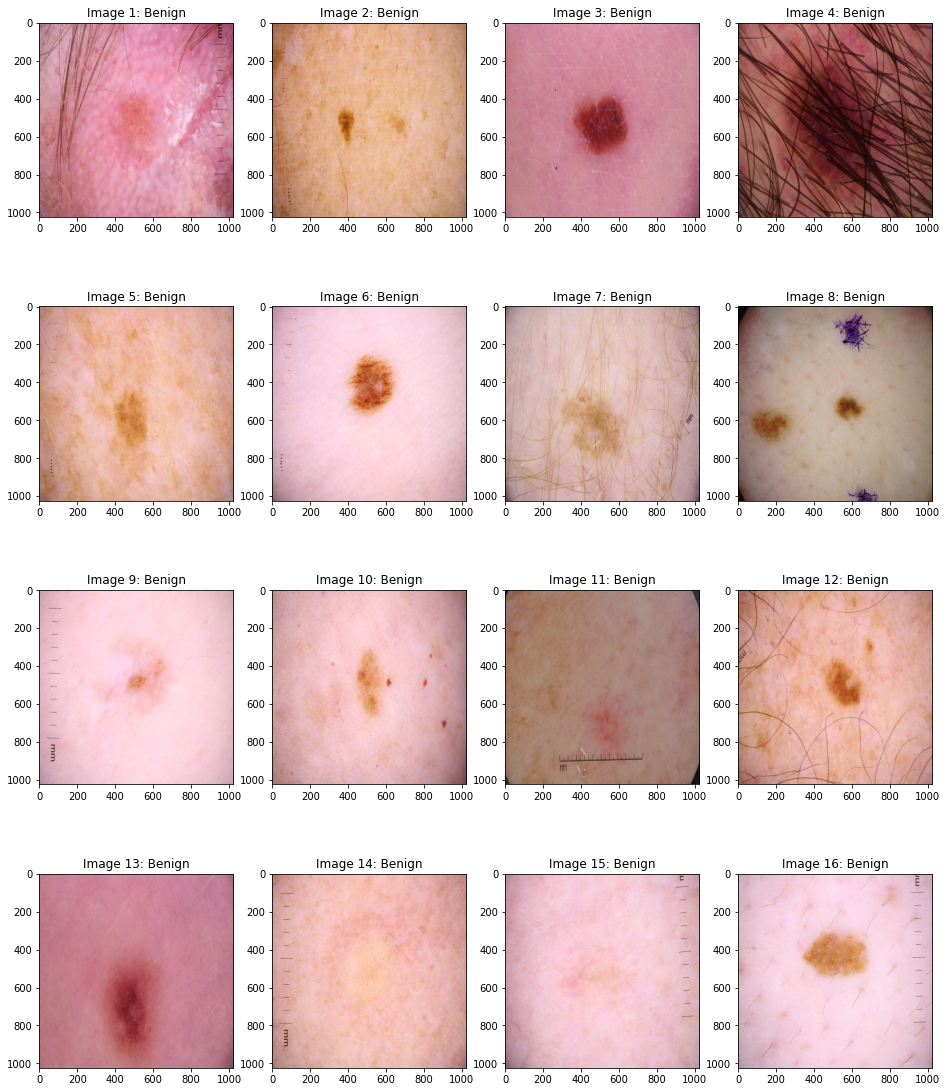

In [22]:
def plot_multiple_images(image_dataframe, rows = 4, columns = 4, figsize = (16, 20), resize=(1024,1024), preprocessing=None, label = 0):
    '''
    Plots Multiple Images
    Reads, resizes, applies preprocessing if desired and plots multiple images from a given dataframe
    '''
    query_string    = 'target == {}'.format(label)
    image_dataframe = image_dataframe.query(query_string).reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []
    base_path = '../input/siim-isic-melanoma-classification/jpeg/train/'
    
    for i in range(rows * columns):
        img = plt.imread(base_path + image_dataframe.loc[i,'image_name'] + '.jpg')
        img = cv2.resize(img, resize)
        
        if preprocessing:
            img = preprocessing(img)
        
        ax.append(fig.add_subplot(rows, columns, i+1) )
        plot_title = "Image {}: {}".format(str(i+1), 'Benign' if label == 0 else 'Malignant') 
        ax[-1].set_title(plot_title)
        plt.imshow(img, alpha=1, cmap='gray')
    
    plt.show()


plot_multiple_images(train_df, label = 0)

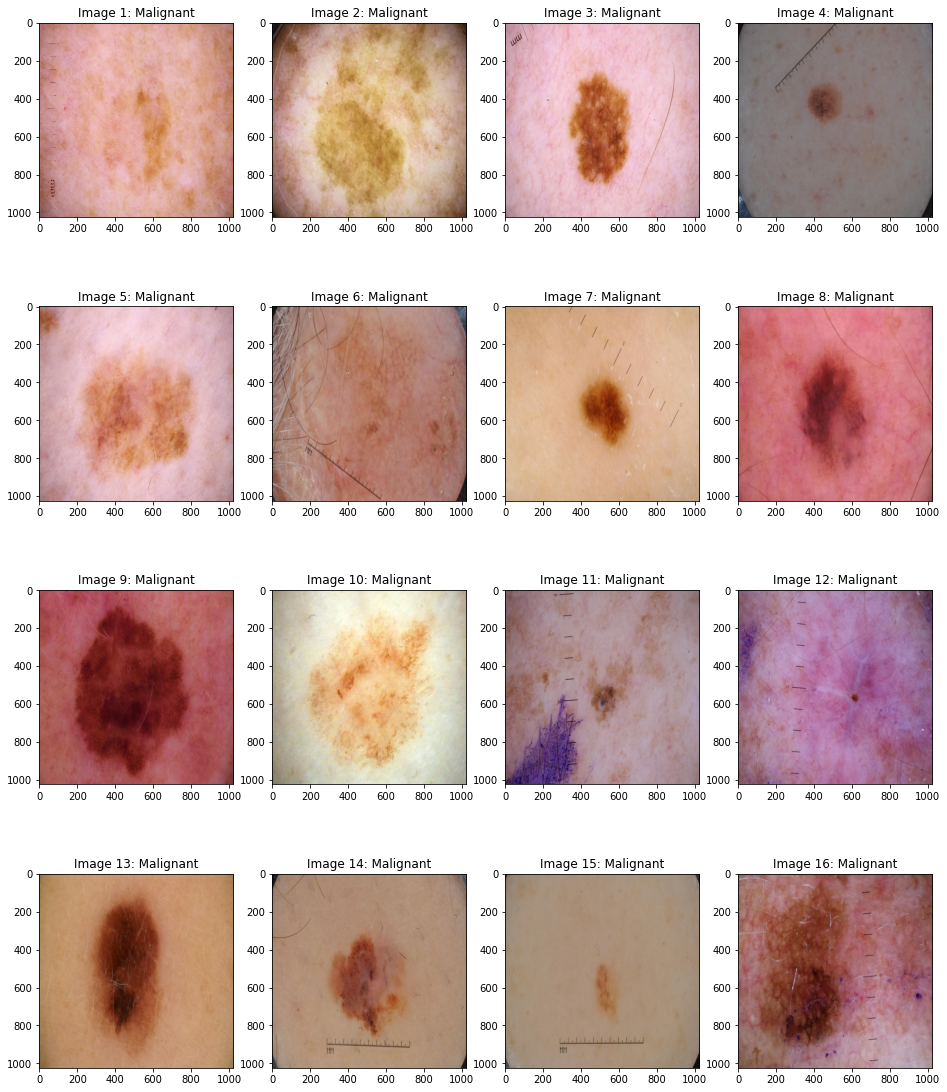

In [23]:
plot_multiple_images(train_df, label = 1)

In [24]:
# For tf.dataset Tensorflow tf. data AUTOTUNE. ... prefetch transformation, 
# which can be used to decouple the time when data is produced from the time when data is consumed. 
# In particular, the transformation uses a background thread and an internal buffer to prefetch 
# elements from the input dataset ahead of the time they are requested.
AUTO = tf.data.experimental.AUTOTUNE

# Get data access to the dataset for TPUs
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

# Running Configuration 
EPOCHS = 5
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]

# Listing the filenames in TFRecords fomat
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')
CLASSES = [0,1]
print('Training filenames\n', TRAINING_FILENAMES)
print('Test file names\n', TEST_FILENAMES)

Training filenames
 ['gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train00-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train01-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train02-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train03-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train04-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train05-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train06-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train07-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train08-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train09-2071.tfrec',

2021-11-24 23:19:25.927365: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-24 23:19:26.008315: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [25]:
VALIDATION_FILENAMES =list(pd.Series(TRAINING_FILENAMES)[[0,1,2]])
TRAINING_FILENAMES = list(pd.Series(TRAINING_FILENAMES)[[3,4,5,6,7,8,9,10,11,12,13,14,15]])
print(TRAINING_FILENAMES)
print(VALIDATION_FILENAMES)

['gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train03-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train04-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train05-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train06-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train07-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train08-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train09-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train10-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train11-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train12-2071.tfrec', 'gs://kds-76608ae53

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='benign_malignant', ylabel='count'>

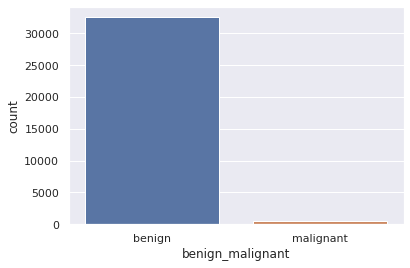

In [26]:
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(train_df['benign_malignant'])

In [27]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        #"class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    #label = tf.cast(example['class'], tf.int32)
    label = tf.cast(example['target'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset


def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


In [28]:
def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (above),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

Dataset Details:
26913 training images,  
6213 validation images 
10982 unlabeled test images


<Figure size 432x288 with 0 Axes>

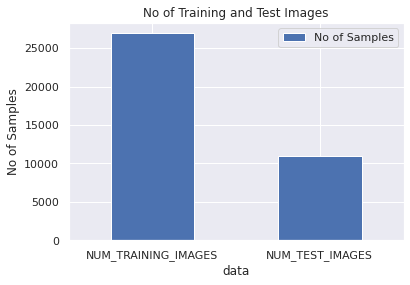

In [29]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
NUM_VALID_IMAGES = count_data_items(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset Details:\n{} training images,  \n{} validation images \n{} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALID_IMAGES, NUM_TEST_IMAGES))


df = pd.DataFrame({'data':['NUM_TRAINING_IMAGES', 'NUM_TEST_IMAGES'],
                   'No of Samples':[NUM_TRAINING_IMAGES, NUM_TEST_IMAGES]})
plt.figure()
x = df.plot.bar(x='data', y='No of Samples', rot=0)
plt.ylabel('No of Samples')
plt.title('No of Training and Test Images')
plt.show()

In [30]:
def build_lrfn(lr_start=0.000002, lr_max=0.00010, 
               lr_min=0, lr_rampup_epochs=8, 
               lr_sustain_epochs=1, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [31]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [32]:
TRAINING = True # set to True if you wanna train ze models!

In [33]:
if TRAINING:
    with strategy.scope():
        model = tf.keras.Sequential([
            efn.EfficientNetB7(
                input_shape=(*IMAGE_SIZE, 3),
                weights='imagenet',
                include_top=False
            ),
            L.GlobalAveragePooling2D(),
            L.Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer='adam',
            loss = 'binary_crossentropy',
            metrics=['accuracy']
        )
        model.summary()

258441216/258434480 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 32, 32, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,241
Trainable params: 63,789,521
Non-trainable params: 310,720
_________________________________________________________________


In [34]:
from tensorflow.keras.applications import DenseNet201

if TRAINING:
    with strategy.scope():
        dnet201 = DenseNet201(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        )
        dnet201.trainable = False

        model2 = tf.keras.Sequential([
            dnet201,
            L.GlobalAveragePooling2D(),
            L.Dense(1, activation='sigmoid')
        ])
        model2.compile(
            optimizer='adam',
            loss = 'binary_crossentropy',
            metrics=['accuracy']
        )

    model2.summary()

74842112/74836368 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 32, 32, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [35]:
if TRAINING:
    history = model.fit(
        train_dataset, 
        epochs=EPOCHS, 
        callbacks=[lr_schedule],
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=valid_dataset
    )
    model.save("efficientnetb7.h5")

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 2e-06.
420/420 [==============================] - 1149s 2s/step - loss: 0.5866 - accuracy: 0.8000 - val_loss: 0.2107 - val_accuracy: 0.9837


2021-11-24 23:39:58.794469: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 151088, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637797198.790279355","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 151088, Output num: 0","grpc_status":3}


Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 1.425e-05.
420/420 [==============================] - 849s 2s/step - loss: 0.1092 - accuracy: 0.9815 - val_loss: 0.0710 - val_accuracy: 0.9837
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6500000000000004e-05.
420/420 [==============================] - 853s 2s/step - loss: 0.0798 - accuracy: 0.9818 - val_loss: 0.0663 - val_accuracy: 0.9837
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 3.875000000000001e-05.
420/420 [==============================] - 861s 2s/step - loss: 0.0731 - accuracy: 0.9821 - val_loss: 0.0635 - val_accuracy: 0.9837
Epoch 5/5

Epoch 00005: LearningRateScheduler reducing learning rate to 5.1000000000000006e-05.
420/420 [==============================] - 849s 2s/step - loss: 0.0742 - accuracy: 0.9818 - val_loss: 0.0628 - val_accuracy: 0.9837


In [36]:
if TRAINING:
    history2 = model2.fit(
        train_dataset, 
        epochs=EPOCHS, 
        callbacks=[lr_schedule],
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=valid_dataset
    )
    model2.save("densenet201.h5")

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 2e-06.
420/420 [==============================] - 334s 706ms/step - loss: 1.3437 - accuracy: 0.0233 - val_loss: 1.2211 - val_accuracy: 0.0309


2021-11-25 00:42:39.388851: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 179651, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637800959.388684036","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 179651, Output num: 0","grpc_status":3}


Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 1.425e-05.
420/420 [==============================] - 258s 615ms/step - loss: 0.9943 - accuracy: 0.1706 - val_loss: 0.5174 - val_accuracy: 0.8675
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6500000000000004e-05.
420/420 [==============================] - 261s 621ms/step - loss: 0.3955 - accuracy: 0.9550 - val_loss: 0.1967 - val_accuracy: 0.9837
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 3.875000000000001e-05.
420/420 [==============================] - 255s 608ms/step - loss: 0.1717 - accuracy: 0.9818 - val_loss: 0.1171 - val_accuracy: 0.9837
Epoch 5/5

Epoch 00005: LearningRateScheduler reducing learning rate to 5.1000000000000006e-05.
420/420 [==============================] - 258s 614ms/step - loss: 0.1183 - accuracy: 0.9811 - val_loss: 0.0954 - val_accuracy: 0.9837


In [37]:
def res_net_block(input_data, filters,fsize,pool = False):
  res = input_data


  if pool:
        input_data = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(input_data)
        input_data = layers.Conv2D(filters, kernel_size=(1, 1), strides=(1,1), padding='same')(input_data)
        res = layers.BatchNormalization()(input_data)   


  x1 =  layers.BatchNormalization()(input_data)
  x1 = layers.Conv2D(filters, fsize, activation='relu', padding='same')(x1)
  x1 = tf.nn.leaky_relu(x1, alpha=0.01, name='Leaky_ReLU')
  x1 = layers.Dropout(0.1)(x1)

  if pool:
    x1 =  layers.BatchNormalization()(x1)
    x1 = tf.nn.leaky_relu(x1, alpha=0.01, name='Leaky_ReLU') 
    x1 = layers.Conv2D(filters=filters, kernel_size=fsize, strides=[1, 1], padding="same")(x1)
    
  x = layers.Add()([ x1 , res ])
  x = tf.nn.leaky_relu(x, alpha=0.01, name='Leaky_ReLU') 
  return x

In [38]:
def hybridnet():
    inputs = keras.Input(shape=(512,512,3))

    x = layers.Conv2D(64, (5, 5), strides = (2, 2), name = 'conv1')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.nn.leaky_relu(x, alpha=0.01, name='Leaky_ReLU') 
    x = layers.MaxPooling2D(3)(x)
    x = layers.Dropout(0.1)(x)

    num_res_net_blocks = 10
    x = res_net_block(x, 64,3,True)
    for i in range(num_res_net_blocks):
        x = res_net_block(x, 64,3)
        
    num_res_net_blocks = 20
    x = res_net_block(x, 128,3,True)
    for i in range(num_res_net_blocks):
        x = res_net_block(x, 128,3)
        
    num_res_net_blocks = 30
    x = res_net_block(x, 256,3,True)
    for i in range(num_res_net_blocks):
        x = res_net_block(x, 256,5)
        
    #xx1 = layers.GlobalAveragePooling2D()(xx1)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu',name='my_dense')(x)
    
    #xx2 = layers.Add()([ xx1 , xx2 ])
    x = layers.Dense(512, activation='relu')(x)
   
    
    x = tf.keras.layers.Dense(out_ptron, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs=x)
    return model

In [39]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

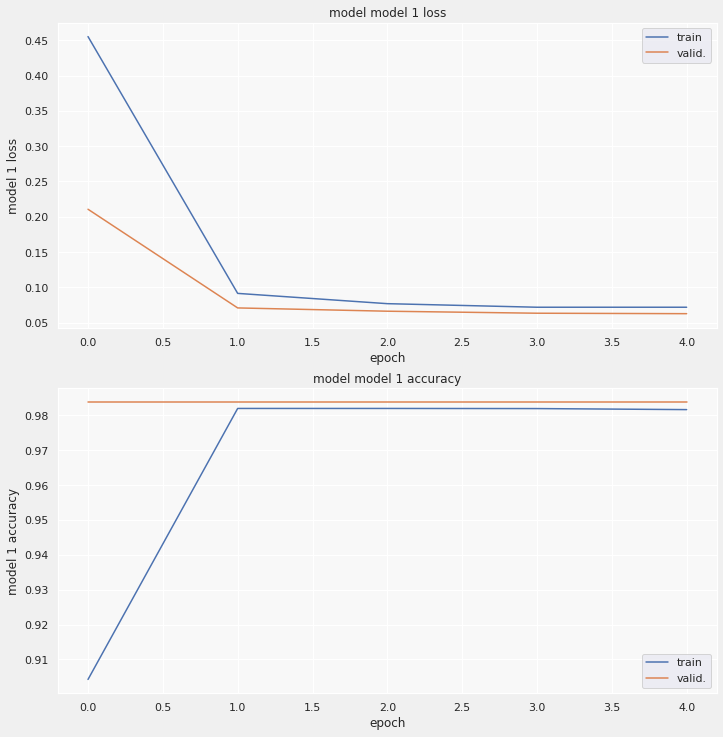

In [40]:
if TRAINING:
    display_training_curves(
        history.history['loss'], 
        history.history['val_loss'], 
        'model 1 loss', 211)
    display_training_curves(
        history.history['accuracy'], 
        history.history['val_accuracy'], 
        'model 1 accuracy', 212)

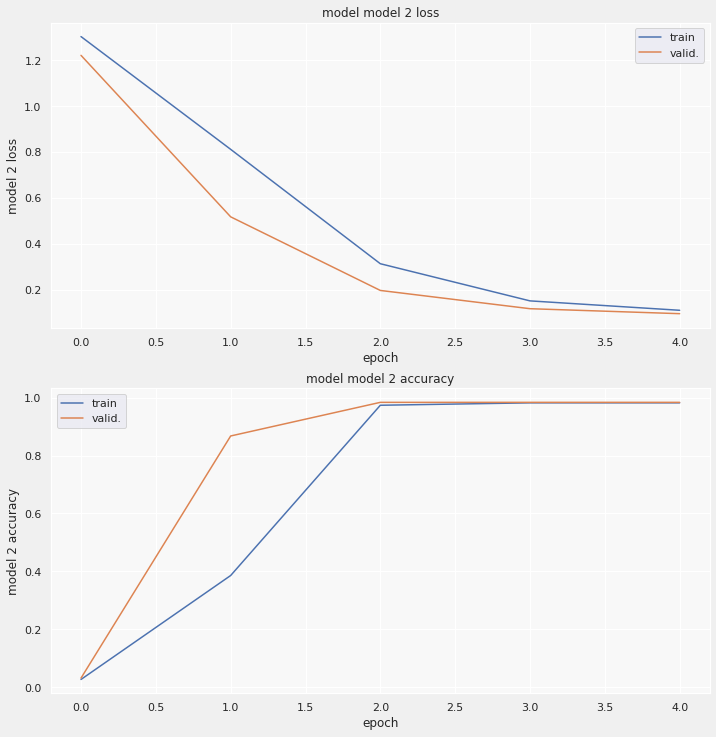

In [41]:
if TRAINING:
    display_training_curves(
        history2.history['loss'], 
        history2.history['val_loss'], 
        'model 2 loss', 211)
    display_training_curves(
        history2.history['accuracy'], 
        history2.history['val_accuracy'], 
        'model 2 accuracy', 212)

In [42]:
if TRAINING:
    test_ds = get_test_dataset(ordered=True)

    print('Computing predictions...')
    test_images_ds = test_ds.map(lambda image, idnum: image)
    probabilities = model.predict(test_images_ds)
    probabilities2 = model2.predict(test_images_ds)
    print('Generating submission.csv file...')
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

Computing predictions...


2021-11-25 01:01:46.352809: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 199278, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637802106.352650772","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 199278, Output num: 0","grpc_status":3}


Generating submission.csv file...


2021-11-25 01:03:19.091818: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 199745, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637802199.091706804","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 199745, Output num: 0","grpc_status":3}


In [43]:
# if TRAINING:
#     pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
#     pred_df2 = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities2)})
#     del sub1['target']
#     sub1 = sub1.merge(pred_df, on='image_name')
#     sub1.to_csv('submission_efficientnetb7.csv', index=False)
#     del sub2['target']
#     sub2 = sub2.merge(pred_df2, on='image_name')
#     sub2.to_csv('submission_efficientnetb0.csv', index=False)

In [44]:
tf.tpu.experimental.initialize_tpu_system(tpu)